In [1]:
# Load Biospytial modules and etc.
%matplotlib inline
import sys
sys.path.append('/apps')
import django
django.setup()
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
## Use the ggplot style
plt.style.use('ggplot')
sys.path.append('..')
import tools
import geopandas as gpd
from HEC_runs.fit_fia_logbiomass_logspp_GLS import prepareDataFrame, createVariogram, buildSpatialStructure,calculateGLS, bundleToGLS, fitLinearLogLogModel

new_data['residuals1'] = results.resid

In [2]:
#new_data = prepareDataFrame("/RawDataCSV/idiv_share/plotsClimateData_11092017.csv")
## En Hec
#new_data = prepareDataFrame("/home/hpc/28/escamill/csv_data/idiv/plotsClimateData_11092017.csv")
## New "official" dataset
new_data = prepareDataFrame("/RawDataCSV/idiv_share/FIA_Plots_Biomass_11092017.csv")

#IN HEC
#new_data = prepareDataFrame("/home/hpc/28/escamill/csv_data/idiv/FIA_Plots_Biomass_11092017.csv")



INFO:HEC_runs.fit_fia_logbiomass_logspp_GLS:Reprojecting to Alberts equal area
INFO:HEC_runs.fit_fia_logbiomass_logspp_GLS:Removing possible duplicates. 
 This avoids problems of Non Positive semidefinite


## Subseting the data

Three different methods for subsetting the data.
1. Using a systematic selection by index modulus
2. Using a random uniform selection by indices.
2. A geographic subselection (Clip)

### Systematic selection

In [3]:
def systSelection(dataframe,k):
    n = len(dataframe)
    idxs = range(0,n,k)
    systematic_sample = dataframe.iloc[idxs]
    return systematic_sample
##################
k = 10 # The k-th element to take as a sample

In [4]:
systematic_sample = systSelection(new_data,k)

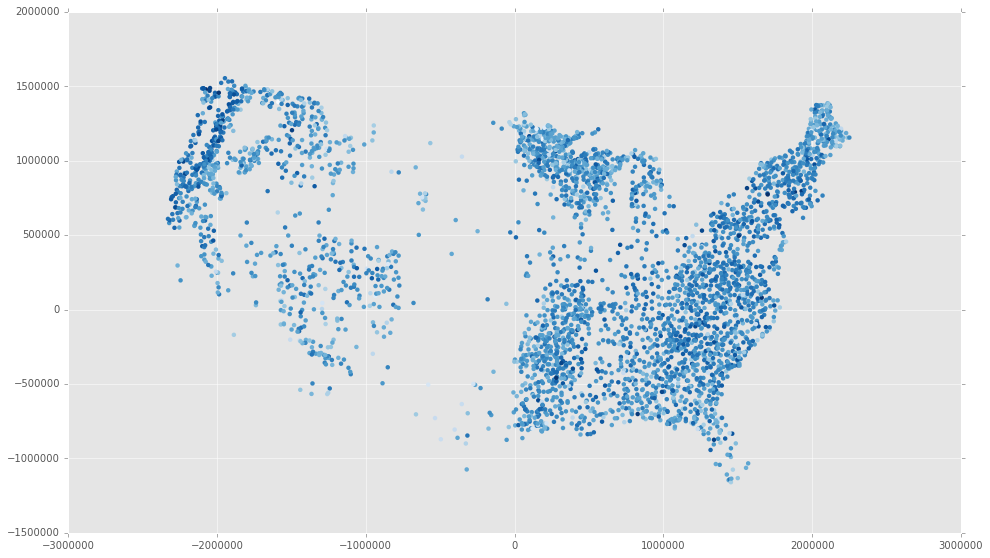

In [5]:
ax= systematic_sample.plot(column='logBiomass',figsize=(16,10),cmap=plt.cm.Blues,edgecolors='') 

### Random (Uniform) selection


In [6]:
def randomSelection(dataframe,p):
    n = len(dataframe)
    idxs = np.random.choice(n,p,replace=False)
    random_sample = dataframe.iloc[idxs]
    return random_sample
#################
n = len(new_data)
p = 3000 # The amount of samples taken (let's do it without replacement)

### Geographic subselection

In [7]:
def subselectDataFrameByCoordinates(dataframe,namecolumnx,namecolumny,minx,maxx,miny,maxy):
    """
    Returns a subselection by coordinates using the dataframe/
    """
    minx = float(minx)
    maxx = float(maxx)
    miny = float(miny)
    maxy = float(maxy)
    section = dataframe[lambda x:  (x[namecolumnx] > minx) & (x[namecolumnx] < maxx) & (x[namecolumny] > miny) & (x[namecolumny] < maxy) ]
    return section

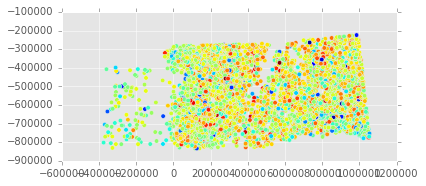

In [8]:
# COnsider the the following subregion
minx = -100
maxx = -85
miny = 30
maxy = 35

section = subselectDataFrameByCoordinates(new_data,'LON','LAT',minx,maxx,miny,maxy)

#section = new_data[lambda x:  (x.LON > minx) & (x.LON < maxx) & (x.LAT > miny) & (x.LAT < maxy) ]
section.plot(column='logBiomass')



## Model Analysis with the empirical variogram


In [9]:
# old variogram (using all data sets)
#gvg,tt = createVariogram("/apps/external_plugins/spystats/HEC_runs/results/logbiomas_logsppn_res.csv",new_data)
## New variogram for new data
gvg,tt = createVariogram("/apps/external_plugins/spystats/HEC_runs/results/variogram/data_envelope.csv",new_data)
#For HEC
#gvg,tt = createVariogram("/home/hpc/28/escamill/spystats/HEC_runs/results/variogram/data_envelope.csv",new_data)


INFO:HEC_runs.fit_fia_logbiomass_logspp_GLS:Reading the empirical Variogram file
INFO:HEC_runs.fit_fia_logbiomass_logspp_GLS:Instantiating a Variogram object with the values calculated before
INFO:HEC_runs.fit_fia_logbiomass_logspp_GLS:Dropping possible Nans
INFO:HEC_runs.fit_fia_logbiomass_logspp_GLS:Instantiating Matern Model...
INFO:HEC_runs.fit_fia_logbiomass_logspp_GLS:fitting Whittle Model with the empirical variogram
../tools.py:561: RuntimeWarning: divide by zero encountered in power
  g_h = ((sill - nugget)*(1 - np.exp(-(h**alpha / range_a**alpha)))) + nugget*Ih
INFO:HEC_runs.fit_fia_logbiomass_logspp_GLS:Model fitted


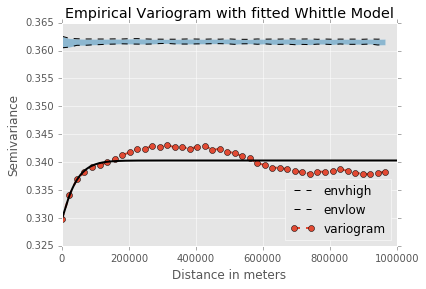

In [10]:
import numpy as np
xx = np.linspace(0,1000000,1000)

gvg.plot(refresh=False)
plt.plot(xx,gvg.model.f(xx),lw=2.0,c='k')
plt.title("Empirical Variogram with fitted Whittle Model")

In [11]:
gvg.model

< Whittle Variogram : sill 0.340288288241, range 40963.3203528, nugget 0.329830410223, alpha1.12279978135 >

In [12]:
samples = map(lambda i : systSelection(new_data,i), range(20,2,-1))
samples = map(lambda i : randomSelection(new_data,3000),range(100))

In [13]:
s = samples[0]
vs = tools.Variogram(s,'logBiomas',model=gvg.model)

In [14]:
%timeit vs.distance_coordinates

1 loop, best of 3: 792 ms per loop


In [15]:
%time vs.model.f(vs.distance_coordinates.flatten())

CPU times: user 1.72 s, sys: 208 ms, total: 1.92 s
Wall time: 1.93 s


array([ 0.32983041,  0.34028829,  0.34023188, ...,  0.34028829,
        0.34028829,  0.32983041])

In [16]:
## let's try to use a better model
vs.model.f(vs.distance_coordinates.flatten())

array([ 0.32983041,  0.34028829,  0.34023188, ...,  0.34028829,
        0.34028829,  0.32983041])

In [17]:
%time vs.model.corr_f(vs.distance_coordinates.flatten()).reshape(vs.distance_coordinates.shape)

CPU times: user 2.91 s, sys: 300 ms, total: 3.21 s
Wall time: 3.22 s


array([[  1.00000000e+00,   0.00000000e+00,   5.39353337e-03, ...,
          0.00000000e+00,   0.00000000e+00,   1.77266030e-02],
       [  0.00000000e+00,   1.00000000e+00,   0.00000000e+00, ...,
          0.00000000e+00,   4.81244666e-07,   0.00000000e+00],
       [  5.39353337e-03,   0.00000000e+00,   1.00000000e+00, ...,
          0.00000000e+00,   0.00000000e+00,   1.51402243e-01],
       ..., 
       [  0.00000000e+00,   0.00000000e+00,   0.00000000e+00, ...,
          1.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       [  0.00000000e+00,   4.81244666e-07,   0.00000000e+00, ...,
          0.00000000e+00,   1.00000000e+00,   0.00000000e+00],
       [  1.77266030e-02,   0.00000000e+00,   1.51402243e-01, ...,
          0.00000000e+00,   0.00000000e+00,   1.00000000e+00]])

In [18]:
matern_model = tools.MaternVariogram(sill=0.340125401705,range_a=5577.83789733, nugget=0.33, kappa=4)
whittle_model = tools.WhittleVariogram(sill=0.340288288241, range_a=40963.3203528, nugget=0.329830410223, alpha=1.12279978135)
exp_model = tools.ExponentialVariogram(sill=0.340294258738, range_a=38507.8253768, nugget=0.329629457808)
gaussian_model = tools.GaussianVariogram(sill=0.340237044718, range_a=44828.0323827, nugget=0.330734960804)
spherical_model = tools.SphericalVariogram(sill=266491706445.0, range_a=3.85462485193e+19, nugget=0.3378323178453)

In [19]:
%time matern_model.f(vs.distance_coordinates.flatten())
%time whittle_model.f(vs.distance_coordinates.flatten())
%time exp_model.f(vs.distance_coordinates.flatten())
%time gaussian_model.f(vs.distance_coordinates.flatten())
%time spherical_model.f(vs.distance_coordinates.flatten())


CPU times: user 7.46 s, sys: 244 ms, total: 7.7 s
Wall time: 7.72 s
CPU times: user 1.68 s, sys: 212 ms, total: 1.9 s
Wall time: 1.91 s
CPU times: user 1.04 s, sys: 204 ms, total: 1.24 s
Wall time: 1.24 s
CPU times: user 1.16 s, sys: 172 ms, total: 1.33 s
Wall time: 1.33 s
CPU times: user 4.11 s, sys: 352 ms, total: 4.46 s
Wall time: 4.47 s


array([ 0.33783232,  0.29551066,  0.33961012, ...,  0.31601169,
        0.28043675,  0.33783232])

In [27]:
%time mcf = matern_model.corr_f(vs.distance_coordinates.flatten())
%time wcf = whittle_model.corr_f(vs.distance_coordinates.flatten())
%time ecf = exp_model.corr_f(vs.distance_coordinates.flatten())
%time gcf = gaussian_model.corr_f(vs.distance_coordinates.flatten())
%time scf = spherical_model.corr_f(vs.distance_coordinates.flatten())


%time mcf0 = matern_model.corr_f_old(vs.distance_coordinates.flatten())
%time wcf0 = whittle_model.corr_f_old(vs.distance_coordinates.flatten())
%time ecf0 = exp_model.corr_f_old(vs.distance_coordinates.flatten())
%time gcf0 = gaussian_model.corr_f_old(vs.distance_coordinates.flatten())
%time scf0 = spherical_model.corr_f_old(vs.distance_coordinates.flatten())


CPU times: user 8.16 s, sys: 316 ms, total: 8.48 s
Wall time: 8.5 s
CPU times: user 2.02 s, sys: 240 ms, total: 2.26 s
Wall time: 2.26 s
CPU times: user 1.12 s, sys: 228 ms, total: 1.35 s
Wall time: 1.35 s
CPU times: user 1.46 s, sys: 228 ms, total: 1.69 s
Wall time: 1.69 s
CPU times: user 4.73 s, sys: 376 ms, total: 5.1 s
Wall time: 5.12 s
CPU times: user 8min 39s, sys: 380 ms, total: 8min 40s
Wall time: 8min 40s
CPU times: user 59.6 s, sys: 304 ms, total: 59.9 s
Wall time: 59.9 s
CPU times: user 52.4 s, sys: 284 ms, total: 52.7 s
Wall time: 52.7 s
CPU times: user 1min 3s, sys: 288 ms, total: 1min 3s
Wall time: 1min 3s


TypeError: 'numpy.float64' object is not iterable

In [33]:
w =  matern_model.corr_f(vs.distance_coordinates.flatten())
w2 = matern_model.corr_f_old(vs.distance_coordinates.flatten())


In [32]:
print(np.array_equal(mcf,mcf0))
print(np.array_equal(wcf,wcf0))
print(np.array_equal(ecf,ecf0))
print(np.array_equal(gcf,gcf0))
#np.array_equal(scf,scf0)

False
True
True
True


In [26]:
np.array_equal()

True

In [ ]:
%time vs.calculateCovarianceMatrix()

## Analysis and Results for the systematic sample

In [ ]:
### read csv files
conf_ints = pd.read_csv("/outputs/gls_confidence_int.csv")
params = pd.read_csv("/outputs/params_gls.csv")
params2 = pd.read_csv("/outputs/params2_gls.csv")

pvals = pd.read_csv("/outputs/pvalues_gls.csv")
pnobs = pd.read_csv("/outputs/n_obs.csv")
prsqs = pd.read_csv("/outputs/rsqs.csv")

In [ ]:
params

In [ ]:
conf_ints

In [ ]:
pvals

In [ ]:
plt.plot(pnobs.n_obs,prsqs.rsq)
plt.title("$R^2$ statistic for GLS on logBiomass ~ logSppn using Sp.autocor")
plt.xlabel("Number of observations")

In [ ]:
tt = params.transpose()

In [ ]:
tt.columns = tt.iloc[0]

In [ ]:
tt = tt.drop(tt.index[0])

In [ ]:
plt.plot(pnobs.n_obs,tt.Intercept)
plt.title("Intercept parameter")

In [ ]:
plt.plot(pnobs.n_obs,tt.logSppN)
plt.title("logSppn parameter")

## Test for analysis

In [ ]:
ccs = map(lambda s : bundleToGLS(s,gvg.model),samples)

In [ ]:
#bundleToGLS(samples[22],gvg.model)
covMat = buildSpatialStructure(samples[8],gvg.model)

In [ ]:
#np.linalg.pinv(covMat)
calculateGLS(samples[8],covMat)
#tt =  covMat.flatten()

In [ ]:
secvg = tools.Variogram(samples[8],'logBiomass',model=gvg.model)

In [ ]:
DM = secvg.distance_coordinates

In [ ]:
dm =  DM.flatten()

In [ ]:
dm.sort()

In [ ]:
pdm = pd.DataFrame(dm)

In [ ]:
xxx = pdm.loc[pdm[0] > 0].sort()

In [ ]:
xxx.shape

In [ ]:
8996780 + 3000 - (3000 * 3000)

In [ ]:
pdm.shape

In [ ]:
dd = samples[22].drop_duplicates(subset=['newLon','newLat'])

In [ ]:
secvg2 = tools.Variogram(dd,'logBiomass',model=gvg.model)

In [ ]:
covMat = buildSpatialStructure(dd,gvg.model)

In [ ]:
calculateGLS(dd,covMat)

In [ ]:
samples[22].shape

In [ ]:
gvg.model.corr_f(xxx.values())

In [ ]:
kk

In [ ]:
gvg.model.corr_f([100])

In [ ]:
gvg.model.corr_f([10])